In [11]:
!pip install timm==0.6.7

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.0/510.0 kB 2.5 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: timm
    Found existing installation: timm 0.4.12
    Uninstalling timm-0.4.12:
      Successfully uninstalled timm-0.4.12
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
salesforce-lavis 1.0.0 requires timm==0.4.12, but you have timm 0.6.7 which is incompatible.
blip-vit 0.0.3 requires timm==0.4.12, but you have timm 0.6.7 which is incompatible.
blip-vit 0.0.3 requires transformers==4.15.0, but you have transformers 4.26.1 which is incompatible.

[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: pip install --upgrade pip


In [ ]:
SD_VERSION = "1_4"
MODEL = 'xception'
IS_VIT = False

In [1]:
from load import SDDDataset
import torch
from torch import nn
from torch.utils.data import DataLoader, random_split
import torch.nn.functional as F
from torchvision import transforms
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from util import tfft, tabs, tlog, tnorm, spec, rand_noise
from torchvision import models
from tqdm import tqdm
import timm

from cleverhans.torch.attacks.fast_gradient_method import fast_gradient_method
from cleverhans.torch.attacks.projected_gradient_descent import (
    projected_gradient_descent,
)

In [2]:
batch_size = 32
spectrogram = False

In [12]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((299, 299)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=.5, hue=.01, saturation=0.1, contrast=0.1),
    transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.001, 5)),
    transforms.Lambda(rand_noise),
    transforms.RandomAffine(degrees=(0, 180), translate=(0, 0.15), fill=1),
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((299, 299)),
])

train_dataset = SDDDataset(real_loc='../data', fake_loc=f'../sdd{SD_VERSION}_results', transform=test_transform, skip=0, samples=40000)
test_dataset = SDDDataset(real_loc='../data', fake_loc=f'../sdd{SD_VERSION}_results', transform=test_transform, skip=40000, samples=10000)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=16)

test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=16)

print(len(train_dataset) + len(test_dataset))

100000


data[0].shape torch.Size([32, 3, 299, 299])
data[1].shape torch.Size([32, 1])


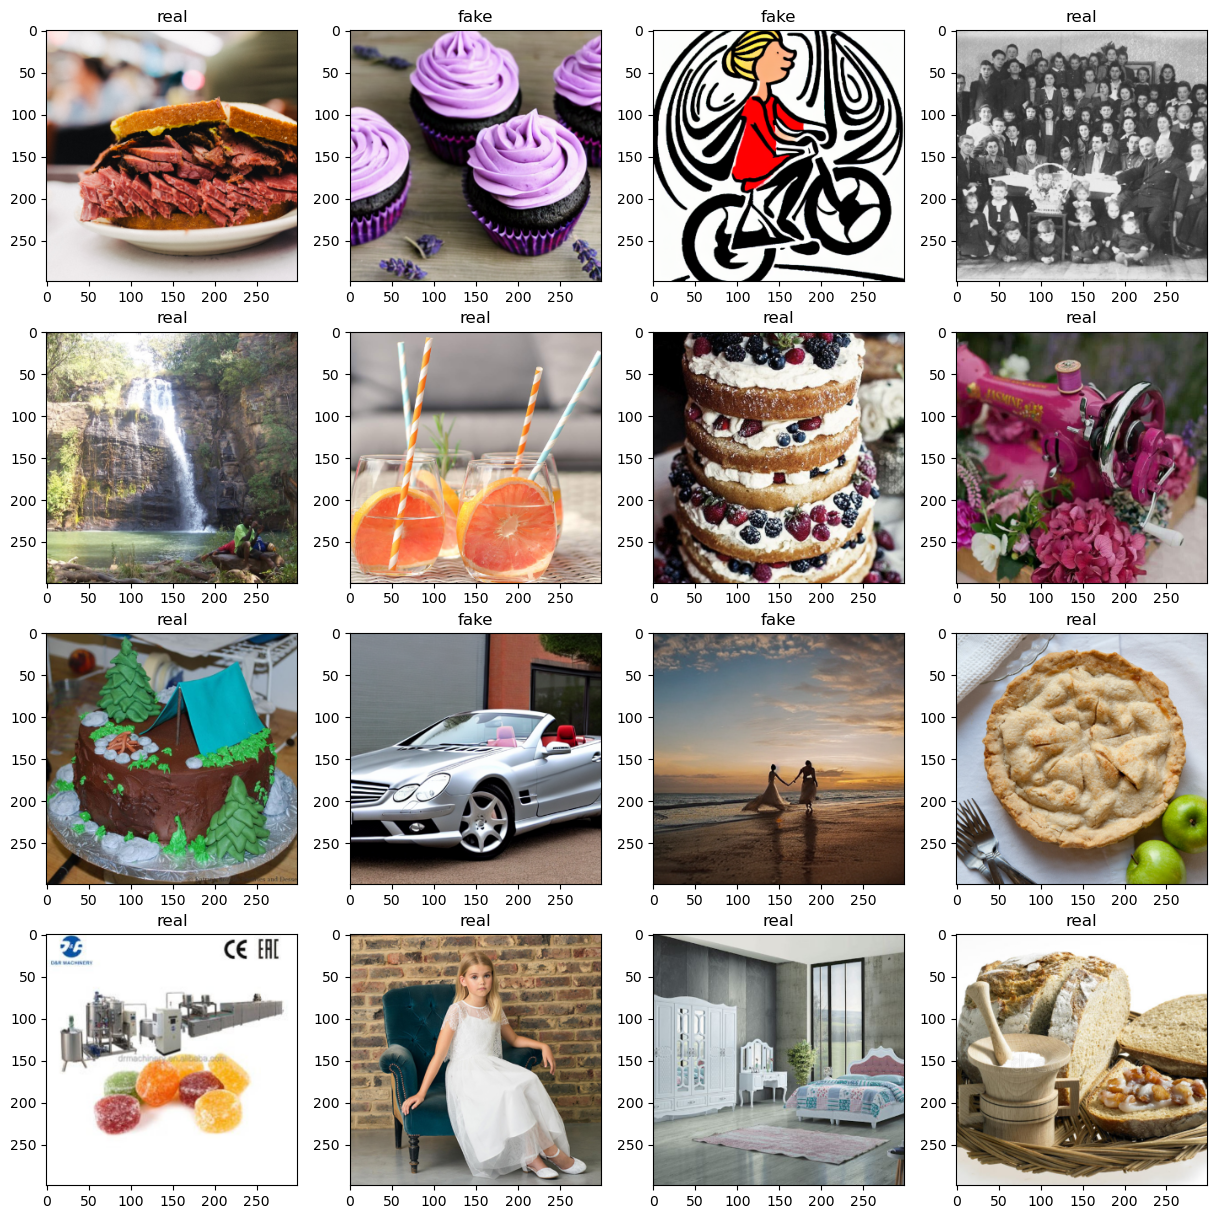

data[0].shape torch.Size([32, 3, 299, 299])
data[1].shape torch.Size([32, 1])


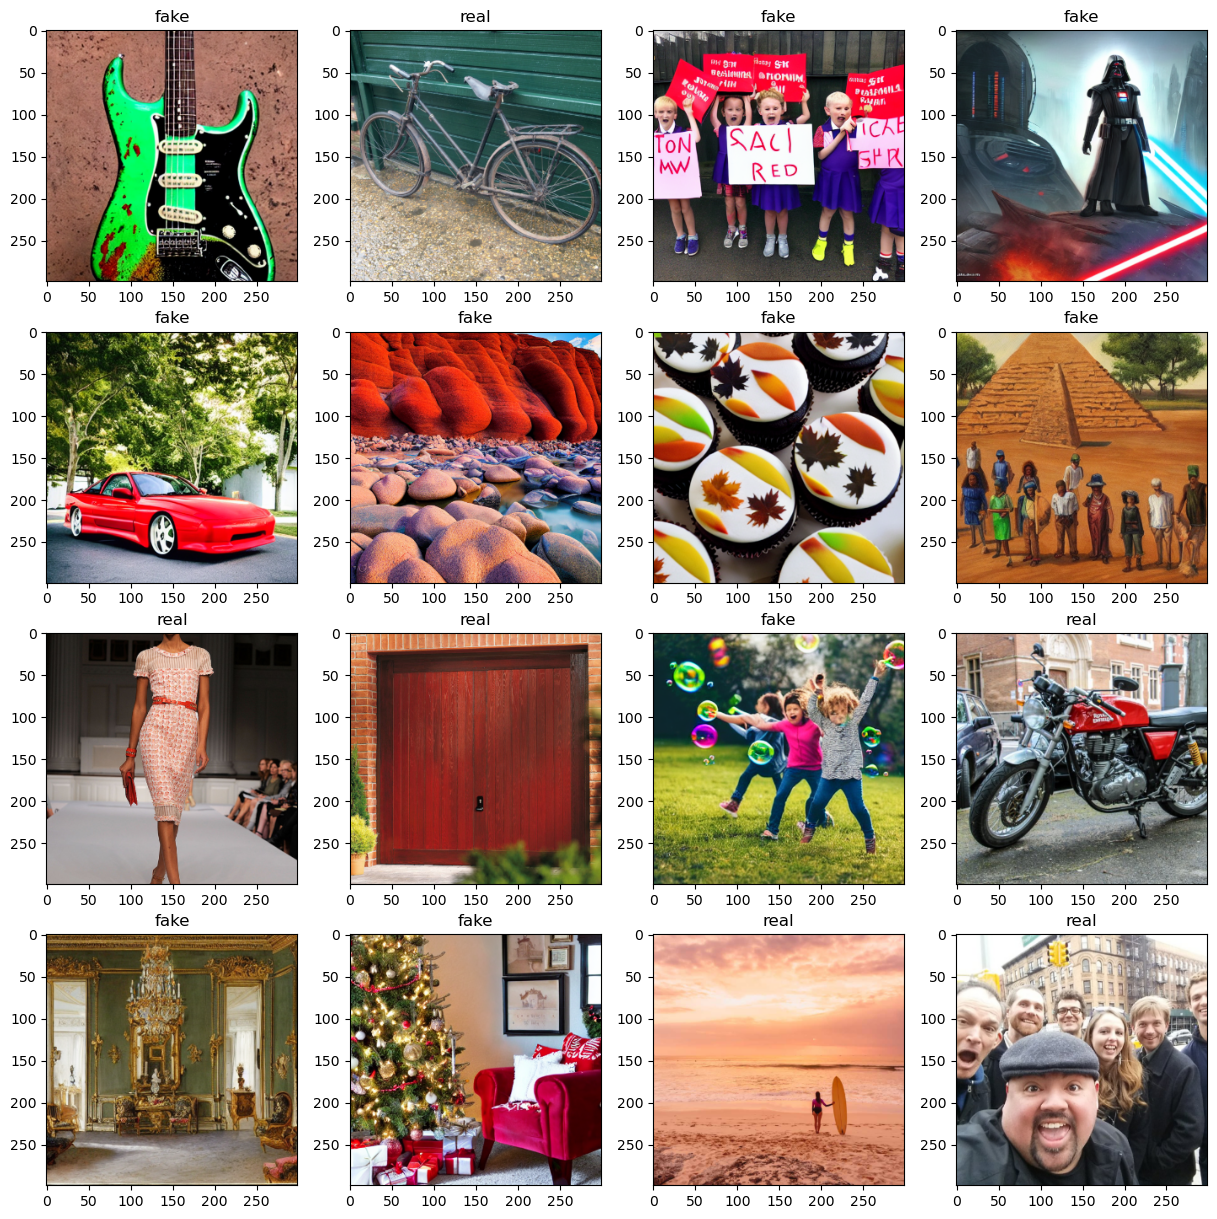

In [4]:
labels = ['fake', 'real']

for i, data in enumerate(iter(train_loader)):
    print('data[0].shape', data[0].shape)
    print('data[1].shape', data[1].shape)

    # Grid of 16 images, 4 rows x 4 columns
    fig, axs = plt.subplots(4, 4, figsize=(15, 15))

    for j in range(16):
        # Get the image and label
        img = data[0][j]
        label = data[1][j][0]

        # Insert the image into the grid
        if spectrogram:
            axs[j // 4, j % 4].imshow((img.permute(1, 2, 0) + 1) / 2, interpolation='none', cmap='jet')
        else:
            axs[j // 4, j % 4].imshow(img.permute(1, 2, 0))
        axs[j // 4, j % 4].set_title(labels[label.item()])

    plt.show()

    break

    
for i, data in enumerate(iter(test_loader)):
    print('data[0].shape', data[0].shape)
    print('data[1].shape', data[1].shape)

    # Grid of 16 images, 4 rows x 4 columns
    fig, axs = plt.subplots(4, 4, figsize=(15, 15))

    for j in range(16):
        # Get the image and label
        img = data[0][j]
        label = data[1][j][0]

        # Insert the image into the grid
        if spectrogram:
            axs[j // 4, j % 4].imshow((img.permute(1, 2, 0) + 1) / 2, interpolation='none', cmap='jet')
        else:
            axs[j // 4, j % 4].imshow(img.permute(1, 2, 0))
        axs[j // 4, j % 4].set_title(labels[label.item()])

    plt.show()

    break


In [5]:
model_names = timm.list_models()
print(timm.__version__)
print([model for model in model_names if model.startswith('xception')])

0.6.7
['xception', 'xception41', 'xception41p', 'xception65', 'xception65p', 'xception71']


In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        print("MPS not available because the current PyTorch install was not "
              "built with MPS enabled.")
    else:
        print("MPS not available because the current MacOS version is not 12.3+ "
              "and/or you do not have an MPS-enabled device on this machine.")

else:
    device = torch.device("mps")


class VisionBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride = 1, padding = 0):
        super(VisionBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels - in_channels, kernel_size, stride, padding)
        self.bn1 = nn.BatchNorm2d(out_channels - in_channels)

        self.conv2 = nn.Conv2d(out_channels - in_channels, out_channels - in_channels, kernel_size, stride, padding)
        self.bn2 = nn.BatchNorm2d(out_channels - in_channels)


    def forward(self, img):
        img_ = self.conv1(img)
        img_ = self.bn1(img_)
        img_ = F.relu(img_)
        img_ = self.conv2(img_)
        img_ = self.bn2(img_)
        img_ = F.relu(img_)

        return torch.cat((img, img_), 1)

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()

        self.conv1 = VisionBlock(3, 16, 5, padding=2)
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv2 = VisionBlock(16, 32, 5, padding=2)
        self.pool2 = nn.MaxPool2d(2, 2)

        self.conv3 = VisionBlock(32, 64, 5, padding=2)
        self.pool3 = nn.MaxPool2d(2, 2)

        self.conv4 = VisionBlock(64, 128, 5, padding=2)
        self.pool4 = nn.MaxPool2d(2, 2)

        self.conv5 = VisionBlock(128, 256, 3, padding=1)
        self.pool5 = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(256 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 124)
        self.fc3 = nn.Linear(124, 1)


    def forward(self, x):
        x = self.pool1(self.conv1(x))
        x = self.pool2(self.conv2(x))
        x = self.pool3(self.conv3(x))
        x = self.pool4(self.conv4(x))
        x = self.pool5(self.conv5(x))

        x = x.view(-1, 256 * 8 * 8)
        x = F.relu(self.fc1(x))

        x = F.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))

        return x

# model = Model()

model = timm.create_model(MODEL, num_classes=2)

# model.AuxLogits.fc = nn.Linear(768, 2)
# model.fc = nn.Linear(2048, 2)

model.to(device)

MPS not available because the current PyTorch install was not built with MPS enabled.


Xception(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act2): ReLU(inplace=True)
  (block1): Block(
    (skip): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
    (skipbn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (rep): Sequential(
      (0): SeparableConv2d(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
        (pointwise): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): SeparableConv2d(
        (conv1): Conv

In [7]:
learning_rate = 1e-5
momentum = 0.9
epochs = 10
criterion = nn.CrossEntropyLoss()

# Learning rate scheduler
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [8]:
## compute accuracy single output
def get_accuracy(logits, labels, batch_size):
    ''' Obtain accuracy for training round '''
    corrects = (logits.argmax(1) == labels).sum().item()
    accuracy = 100.0 * corrects/batch_size
    return accuracy

In [ ]:
optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)
for epoch in range(epochs):
    #Put the model in training mode
    model = model.train()

    train_running_loss = 0.0
    train_acc = 0.0
    for idx, (images, labels) in enumerate(tqdm(train_loader)):
      images = images.to(device)
      labels = labels.reshape((labels.shape[0])).to(device)
      # labels = labels.to(torch.float32).to(device)
    
      #model = model.eval()
      #images = projected_gradient_descent(model, images, 0.01, 0.01, 5, np.inf)
      #model = model.train()

      ## forward + backprop + loss
      #output, aux_output = model(images)
      output = model(images)

      output = torch.softmax(output, dim=1)
      # aux_output = torch.softmax(aux_output, dim=1)

      loss = criterion(output, labels)
      #loss1 = criterion(output, labels)
      #loss2 = criterion(aux_output, labels)
      #loss = loss1 + 0.4*loss2
      optimizer.zero_grad()
      loss.backward()

      ## update model params
      optimizer.step()
      # scheduler.step()

      train_running_loss += loss.detach().item()
      train_acc += get_accuracy(output, labels, labels.shape[0])

    print('Epoch: %d | Loss: %.4f | Train Accuracy: %.2f' \
        %(epoch, train_running_loss / idx, train_acc / idx))

    model = model.eval()
    test_acc = 0.0
    for i, (images, labels) in enumerate(tqdm(test_loader)):
        images = images.to(device)
        labels = labels.reshape((labels.shape[0])).to(device)
        output = torch.softmax(model(images), dim=1)
        test_acc += get_accuracy(output, labels, labels.shape[0])

    print(f"Test Accuracy: {test_acc/i}, in epoch: {epoch}")


100%|██████████| 2500/2500 [11:45<00:00,  3.54it/s]


Epoch: 0 | Loss: 0.4615 | Train Accuracy: 84.60


100%|██████████| 63/63 [00:06<00:00,  9.30it/s]


Test Accuracy: 88.35685483870968, in epoch: 0


100%|██████████| 2500/2500 [11:48<00:00,  3.53it/s]


Epoch: 1 | Loss: 0.4317 | Train Accuracy: 87.58


100%|██████████| 63/63 [00:06<00:00,  9.26it/s]


Test Accuracy: 81.80443548387096, in epoch: 1


100%|██████████| 2500/2500 [11:47<00:00,  3.54it/s]


Epoch: 2 | Loss: 0.4204 | Train Accuracy: 88.82


100%|██████████| 63/63 [00:06<00:00,  9.26it/s]


Test Accuracy: 90.12096774193549, in epoch: 2


100%|██████████| 2500/2500 [11:48<00:00,  3.53it/s]


Epoch: 3 | Loss: 0.4089 | Train Accuracy: 90.06


100%|██████████| 63/63 [00:06<00:00,  9.33it/s]


Test Accuracy: 91.93548387096774, in epoch: 3


100%|██████████| 2500/2500 [11:47<00:00,  3.53it/s]


Epoch: 4 | Loss: 0.3977 | Train Accuracy: 91.26


100%|██████████| 63/63 [00:06<00:00,  9.26it/s]


Test Accuracy: 92.33870967741936, in epoch: 4


100%|██████████| 2500/2500 [11:48<00:00,  3.53it/s]


Epoch: 5 | Loss: 0.3895 | Train Accuracy: 92.25


100%|██████████| 63/63 [00:06<00:00,  9.28it/s]


Test Accuracy: 91.8850806451613, in epoch: 5


100%|██████████| 2500/2500 [11:45<00:00,  3.54it/s]


Epoch: 6 | Loss: 0.3798 | Train Accuracy: 93.25


100%|██████████| 63/63 [00:06<00:00,  9.25it/s]


Test Accuracy: 91.12903225806451, in epoch: 6


100%|██████████| 2500/2500 [11:49<00:00,  3.52it/s]


Epoch: 7 | Loss: 0.3703 | Train Accuracy: 94.25


100%|██████████| 63/63 [00:06<00:00,  9.31it/s]


Test Accuracy: 87.6008064516129, in epoch: 7


100%|██████████| 2500/2500 [11:47<00:00,  3.53it/s]


Epoch: 8 | Loss: 0.3627 | Train Accuracy: 95.02


100%|██████████| 63/63 [00:06<00:00,  9.32it/s]


Test Accuracy: 90.67540322580645, in epoch: 8


 55%|█████▍    | 1369/2500 [06:28<05:18,  3.55it/s]

In [10]:
# model = model.eval()
# test_acc = 0.0
# for i, (images, labels) in enumerate(test_loader):
#     images = images.to(device)
#     labels = labels.to(device)
#     outputs = model(images)
#     test_acc += get_accuracy(outputs, labels, batch_size)

# print(f"Test Accuracy: {test_acc/i}, in epoch: {epoch}")

In [10]:
model = model.eval()
for i, (images, labels) in enumerate(test_loader):
    images = images.to(device)
    labels = labels.to(device)
    outputs = torch.sigmoid(model(images))


    bad_images = []
    bad_preds = []
    bad_labels = []
    indices = (((torch.round(outputs).view(-1) == labels.view(-1)) == False).nonzero().view(-1))
    for index in indices:
        bad_images.append(images[index])
        bad_preds.append(outputs[index])
        bad_labels.append(labels[index])

    if len(bad_images) <= 0:
        continue

    for j in range(len(bad_images)):
        fig, ax = plt.subplots(figsize=(5, 10))
        if spectrogram:
            ax.imshow((bad_images[j].cpu().permute(1, 2, 0) + 1) / 2)
        else:
            ax.imshow(bad_images[j].cpu().permute(1, 2, 0))
        ax.set_title(f"p: {bad_preds[j].item()}, l: {bad_labels[j].item()}")
        plt.show()
    
    if i == 10:
        break


RuntimeError: The size of tensor a (64) must match the size of tensor b (32) at non-singleton dimension 0

100%|██████████| 625/625 [00:57<00:00, 10.90it/s]


Test Accuracy: 90.46474358974359


100%|██████████| 625/625 [00:57<00:00, 10.85it/s]


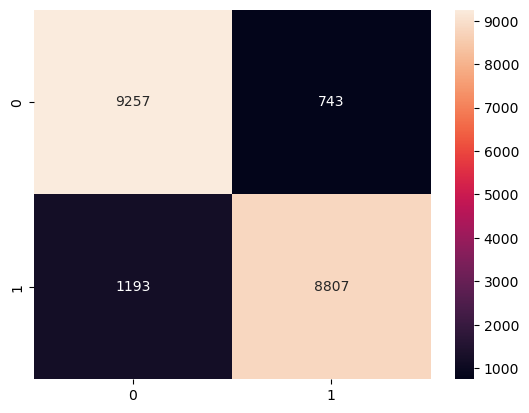

In [13]:
model = model.eval()
test_acc = 0.0
for i, (images, labels) in enumerate(tqdm(test_loader)):
    images = images.to(device)
    labels = labels.reshape((labels.shape[0])).to(device)
    outputs = torch.softmax(model(images), dim=1)
    test_acc += get_accuracy(outputs, labels, batch_size)

print(f"Test Accuracy: {test_acc/i}")


# Confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = []
y_true = []

for i, (images, labels) in enumerate(tqdm(test_loader)):
    images = images.to(device)
    labels = labels.reshape((labels.shape[0])).to(device)
    outputs = torch.softmax(model(images), dim=1)
    y_pred.append(outputs.argmax(dim=1).cpu().detach().numpy())
    y_true.append(labels.view(-1).cpu().detach().numpy())

y_pred = np.concatenate(y_pred)
y_true = np.concatenate(y_true)

cm = confusion_matrix(y_true, y_pred)


sns.heatmap(cm, annot=True, fmt='d')
plt.show()

In [12]:
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

model = model.eval()

def reshape_transform(tensor, height=14, width=14):
    result = tensor[:, 1:, :].reshape(tensor.size(0),
                                      height, width, tensor.size(2))

    # Bring the channels to the first dimension,
    # like in CNNs.
    result = result.transpose(2, 3).transpose(1, 2)
    return result

# target_layers = [model.stages[-1].blocks[-1].conv_dw]
target_layers = [model.blocks[-1].norm1]

for i, (images, labels) in enumerate(test_loader):
    images = images.to(device)
    labels = labels.reshape((labels.shape[0])).to(device)
    outputs = torch.softmax(model(images), dim=1)
    
    cam = GradCAM(model=model, target_layers=target_layers, reshape_transform=reshape_transform)

    grayscale_cam_1 = cam(input_tensor=images, targets=[ClassifierOutputTarget(0) for _ in images])
    grayscale_cam_2 = cam(input_tensor=images, targets=[ClassifierOutputTarget(1) for _ in images])
    for i in range(batch_size):
        plt.imshow(images[i].permute(1, 2, 0).cpu().detach().numpy())
        plt.show()
        plt.imshow(images[i].permute(1, 2, 0).cpu().detach().numpy())
        plt.imshow(torch.ones_like(torch.Tensor(grayscale_cam_1[i, :])), alpha=1-grayscale_cam_1[i, :], cmap='gray')
        plt.title('True label: {} Predicted 0: {}'.format(labels[i].cpu(), outputs[i].cpu()[0]))
        plt.show()
        plt.imshow(images[i].permute(1, 2, 0).cpu().detach().numpy())
        plt.imshow(torch.ones_like(torch.Tensor(grayscale_cam_2[i, :])), alpha=1-grayscale_cam_2[i, :], cmap='gray')
        plt.title('True label: {} Predicted 0: {}'.format(labels[i].cpu(), outputs[i].cpu()[1]))
        plt.show()
    
    break

AttributeError: 'Xception' object has no attribute 'blocks'

In [10]:
torch.save(model.state_dict(), f'saved_models/xception_1_4_no_aug.pth')

In [9]:
model.load_state_dict(torch.load('saved_models/xception_1_4_no_aug.pth'))

<All keys matched successfully>